In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile;
from scipy.ndimage import median_filter
from AV_model import AV_model
from AVGenerator import AVGenerator;
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def real_imag_shrink(F,dim='new'):
    # dim = 'new' or 'same'
    # shrink the complex data to combine real and imag number
    F_shrink = np.zeros((F.shape[0], F.shape[1]))
    if dim =='new':
        F_shrink = F[:,:,0] + F[:,:,1]*1j
    if dim =='same':
        F_shrink = F[:,::2] + F[:,1::2]*1j
    return F_shrink
def istft(F, fft_size=512, step_size=160,padding=True):
    # inverse short time fourier transform
    data = np.fft.irfft(F, axis=-1)
    # padding hanning window 512-400 = 112
    window = np.concatenate((np.zeros((56,)),np.hanning(fft_size-112),np.zeros((56,))),axis=0)
    number_windows = F.shape[0]
    T = np.zeros((number_windows * step_size + fft_size))
    for i in range(number_windows):
        head = int(i * step_size)
        tail = int(head + fft_size)
        T[head:tail] = T[head:tail] + data[i, :] * window
    if padding == True:
        T = T[:48000]
    return T

In [3]:
def inverse_complex_ratio_mask(network_output):
    out = network_output
    K = 10.0
    C = 0.1
    num = K-out
    den = K+out
    return (-1.0/C)*np.log(num/den)

In [4]:
def apply_mask(mask,mix,filename):
    output = []
    for i_source in range(2):
        mask[:,:,:,i_source] = inverse_complex_ratio_mask(mask[:,:,:,i_source]);
        stream = (mask[:,:,0,i_source] + 1j*mask[:,:,1,i_source])*(mix[:,:,0] + 1j*mix[:,:,1])
        stream = np.stack([np.real(stream),np.imag(stream)],axis=2)
        stream = istft(real_imag_shrink(stream))
        output.append(stream)
        wavfile.write(filename+str(i_source)+".wav",16000,stream)
    return output

In [5]:
def evaluate_model(model,data):
    X1 = np.empty((1,298,257,2))
    X1[0,:,:,:] = data["mix"];
    X2 = np.empty((1,75,1,1792,2))
    X2[0,:,:,:,0] = np.expand_dims(data["av_pl"][0],1)
    X2[0,:,:,:,1] = np.expand_dims(data["av_pl"][1],1)
    mask = model.predict([X1,X2])[0,:,:,:,:]
    return mask    

In [6]:
def plot_waveform(audio):
    plt.plot(audio[0],alpha = 0.7, c='k',label='Speaker 1')
    plt.plot(audio[1],alpha = 0.7, c='r',label='Speaker 2')
    plt.axis('off')

In [7]:
def plot_mask(mask):
    i_plot = 1;
    for i_comp in range(1):
        for i_source in range(2):
            plt.subplot(1,2,i_plot)
            plt.imshow(mask[:,:,i_comp,i_source].T,origin='lower')
            plt.clim([-0.8,0.8])
            plt.axis('off')
            title = "Speaker " + str(i_source+1) + ", "
            title += "Real Component" if i_comp==0 else "Imaginary Component"
            plt.title(title)
            i_plot +=1;

In [8]:
model = load_model("checkpoints/lr1em4_logcosh_epoch-200.h5")

In [9]:
data = np.load("data/test_2_3.npy",allow_pickle=True).item()
mix = istft(real_imag_shrink(data["mix"]))
wavfile.write("mix.wav", 16000, mix)

In [10]:
mask = evaluate_model(model,data)

In [11]:
predicted = apply_mask(mask,data["mix"],"stream")
ideal = apply_mask(np.moveaxis(data["mask"],0,3),data["mix"],"ideal_stream")

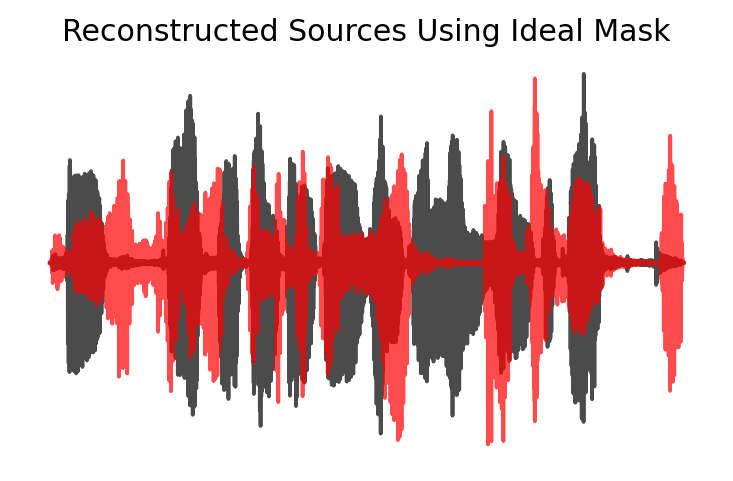

In [12]:
plt.figure(figsize=(5,3),dpi=180)
plot_waveform(ideal)
plt.title('Reconstructed Sources Using Ideal Mask');

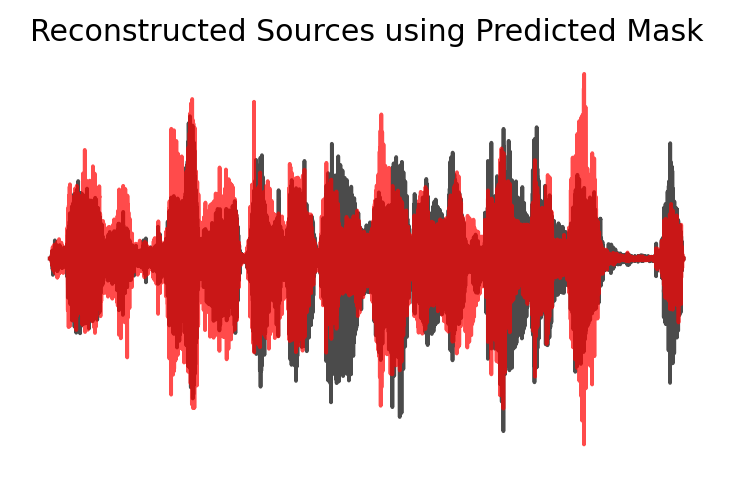

In [13]:
plt.figure(figsize=(5,3),dpi=180)
plot_waveform(predicted)
plt.title("Reconstructed Sources using Predicted Mask");

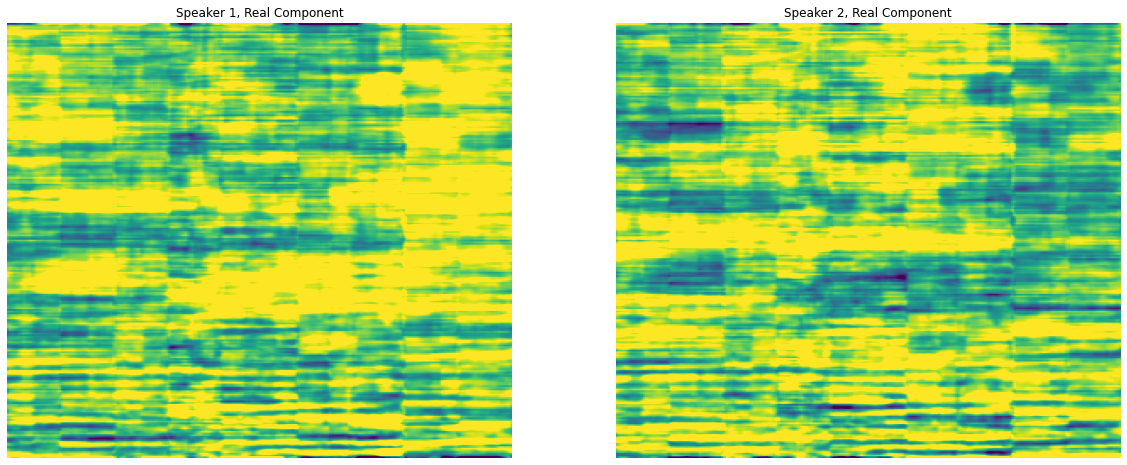

In [14]:
plt.figure(figsize=(20,8))
plot_mask(mask)

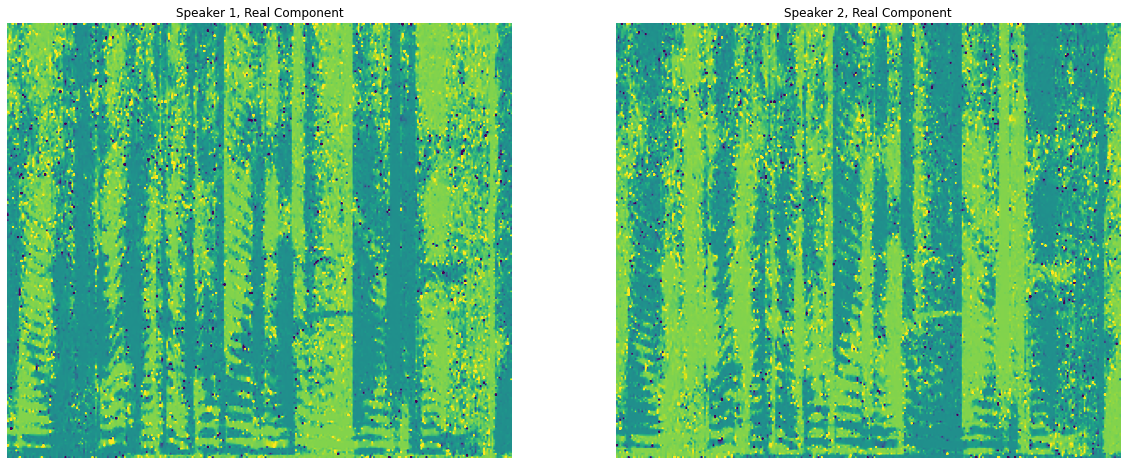

In [15]:
plt.figure(figsize=(20,8))
plot_mask(np.moveaxis(data["mask"],0,3))